# WNTR Basic Tutorial
The following tutorial illustrates basic use of WNTR, including use of the `WaterNetworkModel` object, the ability to read/write model files to other formats, run hydraulic and water quality simulations, compute resilience metrics, define and use fragility curves, skeletonize water network models, identify network segments associated with isolation valves, and assign geospatial data to junctions and pipes.

## Imports
Import WNTR and additional Python packages that are needed for the tutorial
- Numpy is required to define comparison operators (i.e., np.greater) in queries
- Scipy is required to define lognormal fragility curves
- NetworkX is used to compute topographic metrics
- Geopandas is used to load geospatial data
- Matplotlib is required to create graphics

In [3]:
import networkx as nx
import matplotlib.pylab as plt
import wntr

## Units
WNTR uses SI (International System) units (length in meters, time in seconds, mass in kilograms).  See https://usepa.github.io/WNTR/units.html for more details.

# Water Network Model

The `WaterNetworkModel` object defines the water distribution system and simulation options. The object can be created from an EPANET INP file.

In [4]:
# Create a WaterNetworkModel from an EPANET INP file
wn = wntr.network.WaterNetworkModel('Net3.inp')

In [12]:
# Print a basic description of the model.  The level can be 0, 1, or 2 and defines the level of detail included in the description.
wn.describe(level=2)

{'Nodes': {'Junctions': 92, 'Tanks': 3, 'Reservoirs': 2},
 'Links': {'Pipes': 117,
  'Pumps': {'Head': 2, 'Power': 0},
  'Valves': {'PRV': 0, 'PSV': 0, 'PBV': 0, 'TCV': 0, 'FCV': 0, 'GPV': 0}},
 'Patterns': 5,
 'Curves': {'Pump': 2, 'Efficiency': 0, 'Headloss': 0, 'Volume': 0},
 'Sources': 0,
 'Controls': 18}

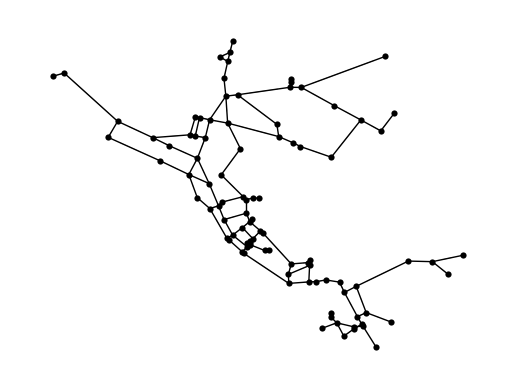

In [33]:
# Plot a basic network graphic
ax = wntr.graphics.plot_network(wn)

## Nodes
Nodes define junctions, tanks, and reservoirs

In [34]:
# Print the names of all junctions, tanks, and reservoirs
print("Node names", wn.node_name_list)

Node names ['10', '15', '20', '35', '40', '50', '60', '601', '61', '101', '103', '105', '107', '109', '111', '113', '115', '117', '119', '120', '121', '123', '125', '127', '129', '131', '139', '141', '143', '145', '147', '149', '151', '153', '157', '159', '161', '163', '164', '166', '167', '169', '171', '173', '177', '179', '181', '183', '184', '185', '187', '189', '191', '193', '195', '197', '199', '201', '203', '204', '205', '206', '207', '208', '209', '211', '213', '215', '217', '219', '225', '229', '231', '237', '239', '241', '243', '247', '249', '251', '253', '255', '257', '259', '261', '263', '265', '267', '269', '271', '273', '275', 'River', 'Lake', '1', '2', '3']


In [35]:
# Print the names of just tanks
print("Tank names", wn.tank_name_list)

Tank names ['1', '2', '3']


In [36]:
# Get a tank object
tank = wn.get_node('1')
print(type(tank))
tank

<class 'wntr.network.elements.Tank'>


<Tank '1', elevation=40.203120000000006, min_level=0.030480000000000004, max_level=9.784080000000001, diameter=25.908, min_vol=0.0, vol_curve='None'>

## Links
Links define pipes, pumps, and valves

In [38]:
# Print the names of all pipes, pumps, and valves
print("Link names", wn.link_name_list)

Link names ['20', '40', '50', '60', '101', '103', '105', '107', '109', '111', '112', '113', '114', '115', '116', '117', '119', '120', '121', '122', '123', '125', '129', '131', '133', '135', '137', '145', '147', '149', '151', '153', '155', '159', '161', '163', '169', '171', '173', '175', '177', '179', '180', '181', '183', '185', '186', '187', '189', '191', '193', '195', '197', '199', '201', '202', '203', '204', '205', '207', '209', '211', '213', '215', '217', '219', '221', '223', '225', '229', '231', '233', '235', '237', '238', '239', '240', '241', '243', '245', '247', '249', '251', '257', '261', '263', '269', '271', '273', '275', '277', '281', '283', '285', '287', '289', '291', '293', '295', '297', '299', '301', '303', '305', '307', '309', '311', '313', '315', '317', '319', '321', '323', '325', '329', '330', '333', '10', '335']


In [39]:
# Print the names of just head pumps
print("Head pump names", wn.head_pump_name_list)

Head pump names ['10', '335']


In [40]:
# Get a pipe object
pipe = wn.get_link('105')
print(type(pipe))
pipe

<class 'wntr.network.elements.Pipe'>


<Pipe '105' from '101' to '105', length=774.192, diameter=0.30479999999999996, roughness=130.0, minor_loss=0.0, check_valve=False, status=Open>

## Demands and Patterns
Junctions can have multiple demands which are stored as Timeseries objects in a `demand_timeseries_list`. Each Timeseries contains a base value, pattern, and category.  Patterns contain multipliers and the pattern timestep.  

The following example illustrates how to
* Compute expected demand (which accounts for base demand, demand patterns, and demand multiplier)
* Compute average expected demand (average value for a 24 hour period -  accounts for base demand, demand patterns, and demand multiplier)
* Add demands to a junction
* Modify demand base value and pattern
* Remove demands from a junction
* Plot expected and simulated demands

In [41]:
# Compute expected demand
expected_demand = wntr.metrics.expected_demand(wn)
expected_demand.head()

,10,15,20,35,40,50,60,601,61,101,...,257,259,261,263,265,267,269,271,273,275
0.0,0.0,0.039116,0.0,0.103279,0.0,0.0,0.0,0.0,0.0,0.016059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3600.0,0.0,0.039116,0.0,0.107632,0.0,0.0,0.0,0.0,0.0,0.023249,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7200.0,0.0,0.039116,0.0,0.108452,0.0,0.0,0.0,0.0,0.0,0.017497,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10800.0,0.0,0.039116,0.0,0.108452,0.0,0.0,0.0,0.0,0.0,0.017257,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14400.0,0.0,0.039116,0.0,0.112995,0.0,0.0,0.0,0.0,0.0,0.009108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


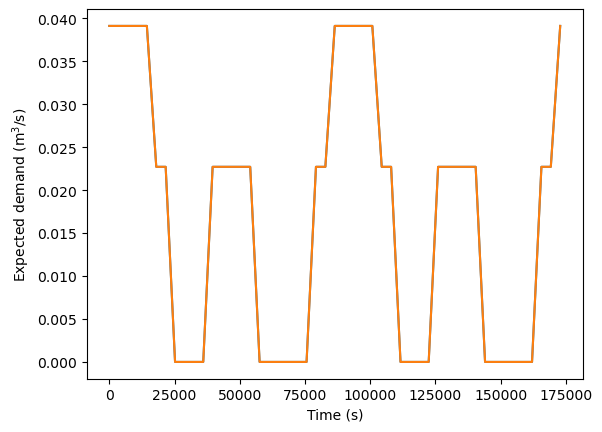

In [42]:
# Plot original and modified expected demands
new_expected_demand = wntr.metrics.expected_demand(wn) 

plt.figure()
ax = expected_demand.loc[0:48*3600, "15"].plot()
new_expected_demand.loc[0:48*3600, "15"].plot(ax=ax)
tmp = ax.set_xlabel('Time (s)')
tmp = ax.set_ylabel('Expected demand (m$^3$/s)')

## Curves
Curves define pump head curves, tank volume curves, and pump efficiency curves.  The following example illustrates how to work with pump head curves and tank volume curves.

<class 'wntr.network.elements.HeadPump'>


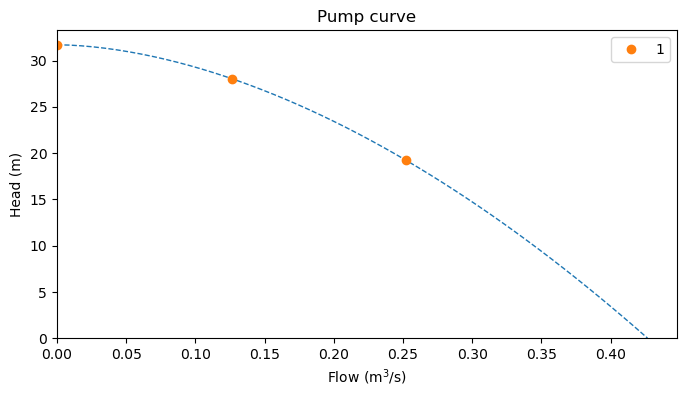

In [43]:
# Get a head pump object and plot the head pump curve
pump = wn.get_link('10')
print(type(pump))
ax = wntr.graphics.plot_pump_curve(pump)

In [44]:
# Get the head curve and print the points
pump_curve_name = pump.pump_curve_name
curve = wn.get_curve(pump_curve_name)
curve.points

[(0.0, 31.6992), (0.1261803928, 28.041600000000003), (0.2523607856, 19.2024)]

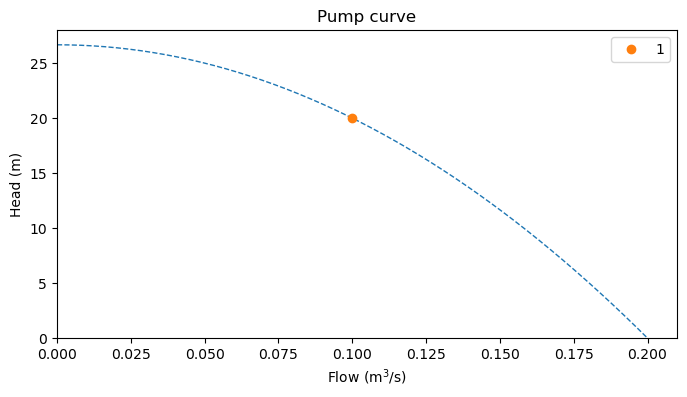

In [45]:
# Modify the curve points and re-plot the pump curve
curve.points = [(0.10, 20)]
ax = wntr.graphics.plot_pump_curve(pump)

## Pipe breaks and leaks
Pipes can be split (adding 1 junction to the model) or broken (adding two junctions to the model) using the `split_pipe` and `break_pipe` functions.  While a split pipe retains the network connectivity, a broken pipe does not connect across the break.  By default these functions return a copy of the WaterNetworkModel.

In [46]:
# Split pipe 123 and add a leak to the new node which starts at hour 2 and ends at hour 12
wn = wntr.morph.split_pipe(wn, pipe_name_to_split='123', new_pipe_name='123_B', new_junction_name='123_node')
leak_node = wn.get_node('123_node')
leak_node.add_leak(wn, area=0.05, start_time=2*3600, end_time=12*3600)

In [47]:
# Break pipe 121
wn = wntr.morph.break_pipe(wn, pipe_name_to_split='121', new_pipe_name='121_B', 
                           new_junction_name_old_pipe='121_node', new_junction_name_new_pipe='121B_node')

## EPANET INP files
WaterNetworkModel objects are commonly built from EPANET INP files.  WaterNetworkModel objects can also be saved as an EPANET INP file. Note that model attributes that are not EPANET compatible will not be saved in the INP file (i.e., leak attributes).

## NetworkX graphs
Graphs facilitate topographic analysis using NetworkX. WaterNetworkModel objects are represented as a MultiDiGraph, which can have multiple edges between nodes and are directed (from start node to end node). Note that WaterNetworkModel objects cannot currently be created from NetworkX graphs.

In [48]:
# Convert the WaterNetworkModel to a MultiDiGraph
G = wntr.network.to_graph(wn)
print(G)

MultiDiGraph with 100 nodes and 121 edges


## Simulation options
Simulation options include options related to simulation time, hydraulics, water quality, reactions, energy calculations, reporting, graphics, and user/custom options.

In [49]:
# Print the WaterNetworkModel options
wn.options

Options(time=TimeOptions(duration=604800.0, hydraulic_timestep=3600, quality_timestep=300, rule_timestep=360, pattern_timestep=3600, pattern_start=0.0, report_timestep=3600, report_start=0.0, start_clocktime=0.0, statistic='NONE', pattern_interpolation=False), hydraulic=HydraulicOptions(headloss='H-W', hydraulics=None, hydraulics_filename=None, viscosity=1.0, specific_gravity=1.0, pattern='1', demand_multiplier=1.0, demand_model='DDA', minimum_pressure=0.0, required_pressure=0.07, pressure_exponent=0.5, emitter_exponent=0.5, trials=40, accuracy=0.001, unbalanced='CONTINUE', unbalanced_value=10, checkfreq=2, maxcheck=10, damplimit=0.0, headerror=0.0, flowchange=0.0, inpfile_units='GPM', inpfile_pressure_units=None), report=ReportOptions(pagesize=0, report_filename=None, status='YES', summary='NO', energy='NO', nodes=False, links=False, report_params={'elevation': False, 'demand': True, 'head': True, 'pressure': True, 'quality': True, 'length': False, 'diameter': False, 'flow': True, 've

In [50]:
# Change the simulation duration to 4 days
wn.options.time.duration = 4*24*3600 # seconds
print(wn.options.time)

TimeOptions(duration=345600.0, hydraulic_timestep=3600, quality_timestep=300, rule_timestep=360, pattern_timestep=3600, pattern_start=0.0, report_timestep=3600, report_start=0.0, start_clocktime=0.0, statistic='NONE', pattern_interpolation=False)


In [51]:
# Change the simulation to use pressure dependent hydraulic analysis
wn.options.hydraulic.demand_model = 'PDD'
wn.options.hydraulic.required_pressure = 20 # m
wn.options.hydraulic.minimum_pressure = 2 # m
print(wn.options.hydraulic)

HydraulicOptions(headloss='H-W', hydraulics=None, hydraulics_filename=None, viscosity=1.0, specific_gravity=1.0, pattern='1', demand_multiplier=1.0, demand_model='PDA', minimum_pressure=2.0, required_pressure=20.0, pressure_exponent=0.5, emitter_exponent=0.5, trials=40, accuracy=0.001, unbalanced='CONTINUE', unbalanced_value=10, checkfreq=2, maxcheck=10, damplimit=0.0, headerror=0.0, flowchange=0.0, inpfile_units='GPM', inpfile_pressure_units=None)


In [53]:
# Simulate hydraulics using the WNTRSimulator
sim = wntr.sim.WNTRSimulator(wn)
results_WNTR = sim.run_sim()

## Simulation results
Simulation results are stored in an object which includes a dictionary of DataFrames for nodes and a dictionary of DataFrames for links.  Each DataFrame is indexed by time (in seconds) and the columns are node or link names.

Text(0, 0.5, 'Pump flowrate (m$^3$/s)')

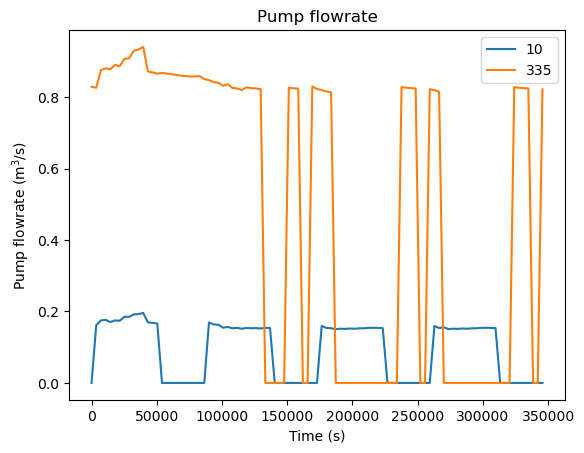

In [54]:
# Plot timeseries of pump flowrates
pump_flowrates = results_WNTR.link['flowrate'].loc[:,wn.pump_name_list]
ax = pump_flowrates.plot(title='Pump flowrate')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pump flowrate (m$^3$/s)')

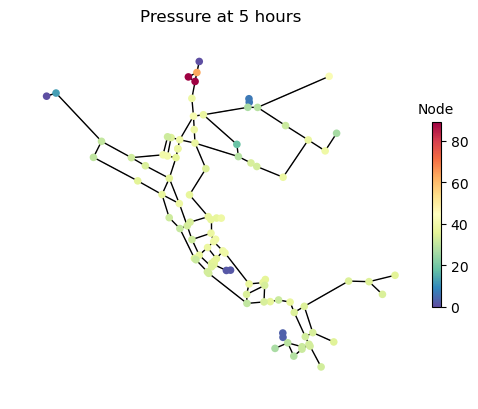

In [55]:
# Plot pressure at hour 5 on the network
pressure_at_5hr = results_WNTR.node['pressure'].loc[5*3600, :]
ax = wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=30, title='Pressure at 5 hours')

## Topographic
Topographic metrics describe the physical layout of the system.

In [56]:
# Convert the WaterNetworkModel to a MultiDiGraph
G = wn.to_graph() # directed multigraph

In [57]:
# Some topographic metrics require an undirected graph or a graph with a single edge between two nodes
uG = G.to_undirected() # undirected multigraph
sG = nx.Graph(uG) # undirected simple graph (single edge between two nodes)

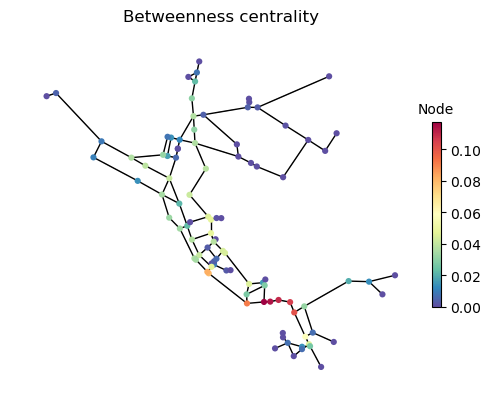

In [59]:
# Compute betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
ax = wntr.graphics.plot_network(wn, node_attribute=betweenness_centrality, title="Betweenness centrality")